## Import Libraries

### Remove cardiffnlp environment

In [ ]:
!rm -rf cardiffnlp

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf

from model import ImageCaptionModel
from decoder import TransformerDecoder, RNNDecoder

from transformers.utils import logging
from generate_caption import memeify_image
logging.set_verbosity_error() 

## Get the presentation of Dataset

In [2]:
## Before this, download the dataset and run preprocessing.py as instructed. 
## This may take like 10 mins, but should only happen once so ok.
## https://www.kaggle.com/datasets/adityajn105/flickr8k?resource=download

with open('../memes900k/data.p', 'rb') as data_file:
    data_dict = pickle.load(data_file)

# As mentioned in the handout, this assignment has 5 captions per image. This block of code 
# expands the image_feature lists to have 5 copies of each image to correspond to each of their captions 
feat_prep = lambda x: np.repeat(np.array(x).reshape(-1, 2048), 100, axis=0)
img_prep  = lambda x: np.repeat(x, 100, axis=0)

## Captions; preprocessed sentences with 20 window size
train_captions  = np.array(data_dict['train_captions']);            print('train_captions:  ', train_captions.shape)
test_captions   = np.array(data_dict['test_captions']);             print('test_captions:   ', test_captions.shape)

## 2048-D resnet embeddings of images.
train_img_feats = feat_prep(data_dict['train_image_features']);     print('\ntrain_img_feats: ', train_img_feats.shape)
test_img_feats  = feat_prep(data_dict['test_image_features']);      print('test_img_feats:  ', test_img_feats.shape)

## Small subset of actual images for visualization purposes. 
## These are just for the first 100 images of each (clones 5 times)
train_images    = img_prep(data_dict['train_images']);              print('\ntrain_images:    ', train_images.shape)
test_images     = img_prep(data_dict['test_images']);               print('test_images:     ', test_images.shape)

## Conversion dictionaries to go between word and label index
word2idx        = data_dict['word2idx']
idx2word        = data_dict['idx2word']

train_captions:   (12000, 21)
test_captions:    (3000, 21)

train_img_feats:  (24000, 2048)
test_img_feats:   (6000, 2048)

train_images:     (10000, 299, 299, 3)
test_images:      (6000, 299, 299, 3)


In [4]:
from read_glove import get_glove_embedding

embeddings_index = get_glove_embedding("../GloVE/glove.6B.300d.txt")
num_tokens = len(word2idx)
embedding_dim = 300
hits = 0
misses = 0
# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word2idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "<start>" and "<end>" and "<unk>" and "<pad>"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        embedding_matrix[i] = tf.random.normal((embedding_dim, ))
        misses += 1

Found 400001 word vectors.


In [5]:
embedding_matrix.shape

(9954, 300)

### Running RNN model


In [8]:
!python main.py --type rnn --task train --data ../memes900k/data.p --epochs 10 --chkpt_path ../rnn_model

Found 400001 word vectors.
Converted 9418 words (536 misses)

[Valid 1/30]	 loss=6.257	 acc: 0.184	 perp: 521.832
[Valid 2/30]	 loss=6.157	 acc: 0.186	 perp: 472.229
[Valid 3/30]	 loss=6.131	 acc: 0.196	 perp: 459.817
[Valid 4/30]	 loss=6.268	 acc: 0.198	 perp: 527.678
[Valid 5/30]	 loss=6.258	 acc: 0.202	 perp: 522.330
[Valid 6/30]	 loss=6.248	 acc: 0.208	 perp: 517.196
[Valid 7/30]	 loss=6.234	 acc: 0.206	 perp: 509.954
[Valid 8/30]	 loss=6.217	 acc: 0.214	 perp: 501.247
[Valid 9/30]	 loss=6.219	 acc: 0.210	 perp: 502.027
[Valid 10/30]	 loss=6.235	 acc: 0.208	 perp: 510.257
[Valid 11/30]	 loss=6.222	 acc: 0.202	 perp: 503.737
[Valid 12/30]	 loss=6.169	 acc: 0.199	 perp: 477.725
[Valid 13/30]	 loss=6.179	 acc: 0.198	 perp: 482.492
[Valid 14/30]	 loss=6.222	 acc: 0.198	 perp: 503.911
[Valid 15/30]	 loss=6.199	 acc: 0.197	 perp: 492.102
[Valid 16/30]	 loss=6.188	 acc: 0.196	 perp: 486.928
[Valid 17/30]	 loss=6.177	 acc: 0.193	 perp: 481.588
[Valid 18/30]	 loss=6.177	 acc: 0.196	 perp: 4

2024-05-04 19:23:47.218003: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.

2024-05-04 19:24:44.124212: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE SSE2 SSE3 SSE4.1 SSE4.2 AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.




### Running Transformer model

In [6]:
!python main.py --type transformer --task train --data ../memes900k/data.p --epochs 10 --lr 0.0005 --chkpt_path ../transform_model

Found 400001 word vectors.
Converted 9418 words (536 misses)

[Valid 1/30]	 loss=6.338	 acc: 0.149	 perp: 565.564
[Valid 2/30]	 loss=6.226	 acc: 0.151	 perp: 505.972
[Valid 3/30]	 loss=6.206	 acc: 0.158	 perp: 495.629
[Valid 4/30]	 loss=6.332	 acc: 0.152	 perp: 562.180
[Valid 5/30]	 loss=6.325	 acc: 0.158	 perp: 558.090
[Valid 6/30]	 loss=6.312	 acc: 0.161	 perp: 551.151
[Valid 7/30]	 loss=6.299	 acc: 0.160	 perp: 544.036
[Valid 8/30]	 loss=6.295	 acc: 0.166	 perp: 542.107
[Valid 9/30]	 loss=6.305	 acc: 0.162	 perp: 547.436
[Valid 10/30]	 loss=6.320	 acc: 0.161	 perp: 555.683
[Valid 11/30]	 loss=6.307	 acc: 0.154	 perp: 548.625
[Valid 12/30]	 loss=6.252	 acc: 0.153	 perp: 519.277
[Valid 13/30]	 loss=6.263	 acc: 0.153	 perp: 524.538
[Valid 14/30]	 loss=6.302	 acc: 0.153	 perp: 545.494
[Valid 15/30]	 loss=6.281	 acc: 0.152	 perp: 534.268
[Valid 16/30]	 loss=6.272	 acc: 0.151	 perp: 529.755
[Valid 17/30]	 loss=6.260	 acc: 0.149	 perp: 523.227
[Valid 18/30]	 loss=6.260	 acc: 0.151	 perp: 5

2024-05-05 09:24:10.665331: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.

2024-05-05 09:25:29.079976: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE SSE2 SSE3 SSE4.1 SSE4.2 AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.





## Save Model

In [8]:
## Feel free to insert auto-reloads as necessary
from main import parse_args, load_model
from decoder import TransformerDecoder, RNNDecoder

## Pull your model into the notebook. This is heavily based off of assignment.py, 
## and feel free to reuse as much as you want. Your final project will probably 
## involve a lot of this investigative reverse-engineering based on what repos 
## you have to stumble upon.
## You're not in a notebook scenario, so use get_default_arguments and feel free to update it...

args = parse_args('--type rnn --task both --data ../memes900k/data.p'.split())

args.chkpt_path = '../transform_model'
tra_imcap = load_model(args)

args.chkpt_path = '../rnn_model'
rnn_imcap = load_model(args)





Model loaded from '../transform_model'
Model loaded from '../rnn_model'


In [9]:
tra_imcap.summary()

Model: "image_caption_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer_decoder (Trans  multiple                  7408554   
 formerDecoder)                                                  
                                                                 
Total params: 7408554 (28.26 MB)
Trainable params: 7408554 (28.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Caption Generation
The below part randomly chooses 20 images in the testing set and generate both filtered and unfiltered captions and their offensive scores to see their difference 

## Visualization - Generate filtered and unfilted captions

In [15]:
indices = np.random.choice(np.array(list(range(0, 6000, 100))), 20, replace=False)

import warnings
warnings.filterwarnings("ignore", message=".*All model checkpoint layers were used.*")

unfiltered_offensive_score = []
average_filtered = []
filtered_offensive_score = []
average_unfiltered = []
curr_image_list = []

for i in indices:
    curr_image_feat = test_img_feats[i]
    curr_image      = test_images[i]
    text1, offensive_score_un = tra_imcap.get_unfiltered_captions(curr_image_feat, word2idx, word2idx['<pad>'], args.window_size)
    unfiltered_offensive_score.append({text1, offensive_score_un})
    average_unfiltered.append(offensive_score_un)
    text2, offensive_score = tra_imcap.get_filtered_captions(curr_image_feat, word2idx, word2idx['<pad>'], args.window_size)
    filtered_offensive_score.append({text2, offensive_score})
    average_filtered.append(offensive_score)
    curr_image_list.append(curr_image)


In [13]:
print("filtered offensive scores", average_filtered)
print("unfilted offensive scores", average_unfiltered)
print("filtered offensive score average: ", tf.reduce_sum(average_filtered) / 20.0)
print("unfilted offensive score average: ", tf.reduce_sum(average_unfiltered) / 20.0)

filtered offensive scores [0.13340634, 0.2038531, 0.22971396, 0.77507734, 0.28488055, 0.21863678, 0.13932084, 0.15715738, 0.27706593, 0.2954309, 0.11183152, 0.17112629, 0.18546033, 0.13299829, 0.24282113, 0.11239971, 0.101350546, 0.27552706, 0.16243091, 0.20524046]
unfilted offensive scores [0.19966973, 0.6694871, 0.53004557, 0.6889154, 0.4253049, 0.3110607, 0.13932084, 0.15715738, 0.12938079, 0.5480012, 0.25373352, 0.17112629, 0.25346497, 0.23064905, 0.14457875, 0.14892095, 0.30375227, 0.22835802, 0.20255385, 0.49982688]
filtered offensive score average:  tf.Tensor(0.22078648, shape=(), dtype=float32)
unfilted offensive score average:  tf.Tensor(0.3117654, shape=(), dtype=float32)


To see a specific image in the list and its scores

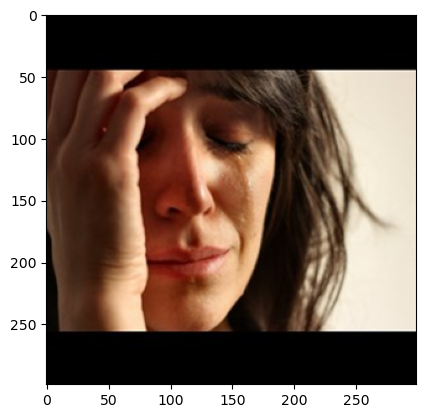

unfiltered score: {0.19966973, 'have no one time sep but it was digiorno'} filtered score: {0.13340634, 'have to have to have to have to have to have to have to have to have to'}


In [14]:
img_num = 0
plt.imshow(curr_image_list[img_num])
plt.show()
print("unfiltered score:", unfiltered_offensive_score[img_num],"filtered score:", filtered_offensive_score[img_num])

## Meme caption generation
Add certain captions to the desired meme and save the new meme

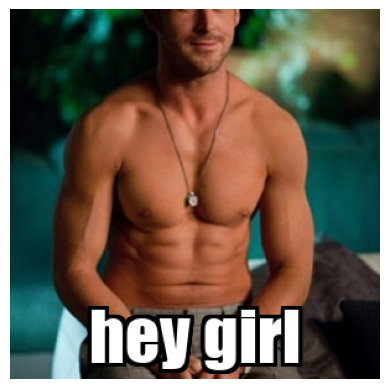

In [5]:
#@title Meme generation and captioning function

from PIL import Image
FONT_PATH = 'fonts/impact.ttf'
import numpy as np

plt.axis("off")

img_path = f'../memes900k/images/shirtless-ryan-gosling.jpg'
with Image.open(img_path) as img:
    img = img.resize((299,299))

tra_caption = "hey girl"
if len(tra_caption.split("sep")) == 1:
    bottom_caption = tra_caption.split("sep")[0]
    top_caption = ''
else:
    bottom_caption = tra_caption.split("sep")[1]
    top_caption = tra_caption.split("sep")[0]
#img = Image.fromarray(curr_image) # 
output = memeify_image(img, top_caption, bottom_caption, font_path=FONT_PATH)
plt.imshow(output)
plt.savefig("generated_images/image1.png", bbox_inches="tight")
    

In [18]:
!pip install Pillow==9.5.0